<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_GNN_TAT_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V4 GNN-TAT: Graph Neural Networks + Temporal Attention for Spatiotemporal Precipitation Prediction

## STHyMOUNTAIN Framework - Version 4

**Author:** Manuel R. Pérez  
**Date:** January 2026  
**Institution:** UPTC - Pedagogical and Technological University of Colombia

---

### Innovation Summary

This notebook implements **Graph Neural Networks with Temporal Attention (GNN-TAT)** for monthly precipitation prediction. Key innovations:

1. **Spatial Graph Representation**: Model grid cells as nodes with edges based on:
   - Geographic distance (inverse weighting)
   - Elevation similarity (orographic effects)
   - Historical precipitation correlation

2. **GNN Encoder**: GraphSAGE/GAT architecture to capture non-Euclidean spatial dependencies

3. **Temporal Attention**: Multi-head attention over the temporal sequence (60 months)

4. **LSTM Decoder**: Sequence-to-sequence prediction with horizon output

### Why GNN-TAT?

- ConvLSTM assumes regular Euclidean grid → fails to capture orographic effects in mountains
- GNN captures non-Euclidean dependencies via learned edge weights
- Temporal attention allows focus on relevant historical patterns
- Interpretable: edge weights reveal spatial dependencies

### Contribution Target

- **Paper**: Nature Communications / Water Resources Research (Q1)
- **Novelty**: First GNN for monthly precipitation prediction on grid data

---

**Version History:**
- V4.0 (Jan 2026): Initial GNN-TAT implementation


## 1. Environment Setup and Imports

In [1]:
# =============================================================================
# CELL 1: Environment Detection and Package Installation
# =============================================================================

import os
import sys
import shutil

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

# Version info from local machine where dataset was created
LOCAL_VERSIONS = {
    'netCDF4': '1.7.2',
    'h5py': '3.14.0',
    'HDF5_lib': '1.14.4',
    'netCDF_lib': '4.9.2'
}

if IN_COLAB:
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    # Install PyTorch Geometric - FAST method
    import subprocess

    subprocess.run([
        sys.executable, '-m', 'pip', 'install',
        'torch-geometric', '-q'
    ], check=True)

    # Install specific versions matching local environment to avoid HDF5 incompatibility
    subprocess.run([
        sys.executable, '-m', 'pip', 'install',
        f"netcdf4=={LOCAL_VERSIONS['netCDF4']}",
        f"h5py=={LOCAL_VERSIONS['h5py']}",
        'xarray', 'h5netcdf', '-q'
    ], check=True)

    # Check installed versions and warn if different
    import netCDF4
    import h5py

    print(f"\nVersion check:")
    print(f"  netCDF4: {netCDF4.__version__} (local: {LOCAL_VERSIONS['netCDF4']})")
    print(f"  h5py: {h5py.__version__} (local: {LOCAL_VERSIONS['h5py']})")
    print(f"  HDF5 lib: {netCDF4.__hdf5libversion__} (local: {LOCAL_VERSIONS['HDF5_lib']})")
    print(f"  netCDF lib: {netCDF4.__netcdf4libversion__} (local: {LOCAL_VERSIONS['netCDF_lib']})")

    # Warn about version mismatches
    if netCDF4.__version__ != LOCAL_VERSIONS['netCDF4']:
        print(f"  WARNING: netCDF4 version mismatch!")
    if netCDF4.__hdf5libversion__ != LOCAL_VERSIONS['HDF5_lib']:
        print(f"  WARNING: HDF5 library version mismatch - may cause read errors!")

    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'

    # Copy dataset to local disk for faster access
    DRIVE_DATA_FILE = f"{BASE_PATH}/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc"
    LOCAL_DATA_FILE = '/content/dataset_local.nc'

    if os.path.exists(DRIVE_DATA_FILE):
        if not os.path.exists(LOCAL_DATA_FILE):
            print(f"\nCopying dataset to local disk...")
            shutil.copy(DRIVE_DATA_FILE, LOCAL_DATA_FILE)
            print("  Copy completed!")
        else:
            print(f"\nUsing cached local dataset: {LOCAL_DATA_FILE}")
        USE_LOCAL_DATA = True
    else:
        print(f"WARNING: Dataset not found: {DRIVE_DATA_FILE}")
        USE_LOCAL_DATA = False
else:
    print("Running locally")
    BASE_PATH = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
    if not BASE_PATH or BASE_PATH == '':
        BASE_PATH = r'd:\github.com\ninja-marduk\ml_precipitation_prediction'
    USE_LOCAL_DATA = False
    LOCAL_DATA_FILE = None

print(f"\nBase path: {BASE_PATH}")

if BASE_PATH not in sys.path:
    sys.path.insert(0, BASE_PATH)

print("Installation complete!")

Running in Google Colab
Mounted at /content/drive

Version check:
  netCDF4: 1.7.2 (local: 1.7.2)
  h5py: 3.14.0 (local: 3.14.0)
  HDF5 lib: 1.14.2 (local: 1.14.4)
  netCDF lib: 4.9.4-development (local: 4.9.2)

Copying dataset to local disk...
  Copy completed!

Base path: /content/drive/MyDrive/ml_precipitation_prediction
Installation complete!


In [2]:
# =============================================================================
# CELL 2: Core Imports
# =============================================================================

# Disable TF oneDNN warnings before importing
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore')

# Core scientific computing
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

# PyTorch and PyTorch Geometric for GNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PyTorch Geometric
try:
    import torch_geometric
    from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
    from torch_geometric.data import Data, Batch
    from torch_geometric.utils import dense_to_sparse, to_dense_adj
    TORCH_GEOMETRIC_AVAILABLE = True
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("WARNING: PyTorch Geometric not available. Install with pip install torch-geometric")

# TensorFlow for compatibility with existing pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Utilities
import gc
import json
import time
import logging
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

try:
    import geopandas as gpd
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY_AVAILABLE = True
except ImportError:
    CARTOPY_AVAILABLE = False

try:
    import imageio.v2 as imageio
    IMAGEIO_AVAILABLE = True
except ImportError:
    IMAGEIO_AVAILABLE = False

# Print versions
print(f"\nEnvironment Summary:")
print(f"  PyTorch: {torch.__version__}")
print(f"  TensorFlow: {tf.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch Geometric version: 2.7.0

Environment Summary:
  PyTorch: 2.9.0+cu126
  TensorFlow: 2.19.0
  NumPy: 2.0.2
  CUDA available: True
  CUDA device: NVIDIA A100-SXM4-80GB


## 2. Configuration

In [3]:
# =============================================================================
# CELL 3: Configuration Dictionary (V2/V3 Compatible) - OPTIMIZED
# =============================================================================
# Changes: Added parametrized graph construction values, reduced num_gnn_layers

CONFIG = {
    # -------------------------------------------------------------------------
    # Data and Paths
    # -------------------------------------------------------------------------
    'input_window': 60,           # Number of historical months
    'horizon': 12,                # Prediction horizon (months ahead)
    'base_path': Path(BASE_PATH),
    'data_file': None,            # Auto-set below
    'out_root': None,             # Auto-set below

    # -------------------------------------------------------------------------
    # Model Training
    # -------------------------------------------------------------------------
    'epochs': 150,
    'batch_size': 4,              # Slightly larger for GNN efficiency
    'learning_rate': 1e-3,
    'patience': 50,               # Early stopping patience
    'gradient_accumulation_steps': 1,
    'prediction_batch_size': 2,
    'weight_decay': 1e-5,         # L2 regularization for GNN

    # -------------------------------------------------------------------------
    # Data Handling
    # -------------------------------------------------------------------------
    'train_val_split': 0.8,
    'light_mode': True,           # Subset for quick testing
    'light_grid_size': 5,         # 5x5 pixel subset (25 nodes for GNN)
    'loss_weighting': 'uniform',
    'save_window_metrics': False,

    # -------------------------------------------------------------------------
    # Horizons to Run
    # -------------------------------------------------------------------------
    'enabled_horizons': [12],     # Can be [3, 6, 12] for multi-horizon

    # -------------------------------------------------------------------------
    # Feature Sets (V2/V3 Compatible)
    # -------------------------------------------------------------------------
    'feature_sets': {
        'BASIC': [
            'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
            'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
            'elevation', 'slope', 'aspect'
        ],
        'KCE': [
            'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
            'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
            'elevation', 'slope', 'aspect', 'elev_high', 'elev_med', 'elev_low'
        ],
        'PAFC': [
            'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
            'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
            'elevation', 'slope', 'aspect', 'elev_high', 'elev_med', 'elev_low',
            'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag12'
        ]
    },

    # -------------------------------------------------------------------------
    # GNN-TAT Specific Configuration
    # -------------------------------------------------------------------------
    'gnn_config': {
        'hidden_dim': 64,              # GNN hidden dimension
        'num_gnn_layers': 2,           # Number of GNN layers (reduced from 3)
        'gnn_type': 'GAT',             # 'GAT', 'SAGE', 'GCN'
        'num_heads': 4,                # Attention heads for GAT
        'dropout': 0.1,                # Dropout rate

        # Temporal Attention
        'temporal_hidden_dim': 64,     # Temporal attention hidden dim
        'num_temporal_heads': 4,       # Multi-head attention heads
        'temporal_dropout': 0.1,

        # LSTM Decoder
        'lstm_hidden_dim': 64,         # LSTM hidden dimension
        'num_lstm_layers': 2,          # Number of LSTM layers

        # Graph Construction
        'edge_threshold': 0.3,         # Correlation threshold for edges
        'max_neighbors': 8,            # Maximum neighbors per node (k-NN)
        'use_distance_edges': True,    # Include distance-based edges
        'use_elevation_edges': True,   # Include elevation-based edges
        'use_correlation_edges': True, # Include correlation-based edges

        # Graph construction parameters (previously hardcoded)
        'distance_scale_km': 10.0,     # Scale for distance similarity
        'elevation_scale': 0.2,        # Scale for elevation similarity
        'elevation_weight': 0.3,       # Weight for elevation edges
        'correlation_weight': 0.5,     # Weight for correlation edges
        'min_edge_weight': 0.01,       # Minimum edge weight to keep
    }
}

# Auto-set paths (V2/V3 Compatible - same dataset)
# Use local copy in Colab for faster/reliable access
if IN_COLAB and USE_LOCAL_DATA:
    CONFIG['data_file'] = Path(LOCAL_DATA_FILE)
else:
    CONFIG['data_file'] = CONFIG['base_path'] / 'data' / 'output' / (
        'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
    )
CONFIG['out_root'] = CONFIG['base_path'] / 'models' / 'output' / 'V4_GNN_TAT_Models'

# Create output directory
CONFIG['out_root'].mkdir(parents=True, exist_ok=True)

print("Configuration loaded:")
print(f"  Input window: {CONFIG['input_window']} months")
print(f"  Horizon: {CONFIG['horizon']} months")
print(f"  Light mode: {CONFIG['light_mode']} ({CONFIG['light_grid_size']}x{CONFIG['light_grid_size']} grid)")
print(f"  GNN type: {CONFIG['gnn_config']['gnn_type']}")
print(f"  Hidden dim: {CONFIG['gnn_config']['hidden_dim']}")
print(f"  Output directory: {CONFIG['out_root']}")

Configuration loaded:
  Input window: 60 months
  Horizon: 12 months
  Light mode: True (5x5 grid)
  GNN type: GAT
  Hidden dim: 64
  Output directory: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models


## 3. Data Loading and Validation

In [4]:
# =============================================================================
# CELL 4: Data Loading Functions (V2/V3 Compatible) - IMPROVED
# =============================================================================
# Changes:
# - Better feature validation
# - Multiple NetCDF engines for compatibility (h5netcdf fallback)

def load_and_validate_data(config: Dict) -> Tuple[xr.Dataset, int, int, np.ndarray, np.ndarray]:
    """
    Load dataset and validate features, applying light mode if enabled.
    Tries multiple NetCDF engines for compatibility.
    """
    data_file = config['data_file']
    light_mode = config['light_mode']
    light_grid_size = config['light_grid_size']

    print(f"Loading data from: {data_file}")

    if not Path(data_file).exists():
        raise FileNotFoundError(f"Data file not found: {data_file}")

    # Try multiple engines for NetCDF compatibility
    engines = ['h5netcdf', 'netcdf4', 'scipy']
    ds = None

    for engine in engines:
        try:
            print(f"  Trying engine: {engine}...")
            ds = xr.open_dataset(data_file, engine=engine)
            print(f"  Success with engine: {engine}")
            break
        except Exception as e:
            print(f"  Engine {engine} failed: {type(e).__name__}")
            continue

    if ds is None:
        raise RuntimeError(f"Could not open dataset with any engine. File may be corrupted.")

    print(f"  Original shape: time={len(ds.time)}, lat={len(ds.latitude)}, lon={len(ds.longitude)}")

    # Optional light mode: subset to center region
    if light_mode:
        lat_center = len(ds.latitude) // 2
        lon_center = len(ds.longitude) // 2
        lat_start = lat_center - light_grid_size // 2
        lat_end = lat_start + light_grid_size
        lon_start = lon_center - light_grid_size // 2
        lon_end = lon_start + light_grid_size

        ds = ds.isel(
            latitude=slice(lat_start, lat_end),
            longitude=slice(lon_start, lon_end)
        )
        print(f"  Light mode applied: lat={len(ds.latitude)}, lon={len(ds.longitude)}")

    n_lat = len(ds.latitude)
    n_lon = len(ds.longitude)
    lat_coords = ds.latitude.values
    lon_coords = ds.longitude.values

    # Validate features
    available_vars = set(list(ds.data_vars) + list(ds.coords))
    missing_by_exp = {}
    critical_missing = []

    for exp_name, feats in config['feature_sets'].items():
        missing = [f for f in feats if f not in available_vars]
        if missing:
            missing_by_exp[exp_name] = missing
            if 'total_precipitation' in missing:
                critical_missing.append('total_precipitation')

    if missing_by_exp:
        print(f"  WARNING: Missing features by experiment:")
        for exp, feats in missing_by_exp.items():
            print(f"    {exp}: {feats}")

        if critical_missing:
            raise ValueError(f"Critical features missing: {critical_missing}")
        print(f"  Continuing with available features...")
    else:
        print(f"  All features validated successfully")

    return ds, n_lat, n_lon, lat_coords, lon_coords


# Load data
ds, lat, lon, lat_coords, lon_coords = load_and_validate_data(CONFIG)

print(f"\nData loaded:")
print(f"  Grid size: {lat} x {lon} = {lat * lon} nodes")
print(f"  Time steps: {len(ds.time)}")
print(f"  Latitude range: [{lat_coords.min():.4f}, {lat_coords.max():.4f}]")
print(f"  Longitude range: [{lon_coords.min():.4f}, {lon_coords.max():.4f}]")

Loading data from: /content/dataset_local.nc
  Trying engine: h5netcdf...
  Success with engine: h5netcdf
  Original shape: time=518, lat=61, lon=65
  Light mode applied: lat=5, lon=5
  All features validated successfully

Data loaded:
  Grid size: 5 x 5 = 25 nodes
  Time steps: 518
  Latitude range: [5.7750, 5.9750]
  Longitude range: [-73.4250, -73.2250]


## 4. Graph Construction for GNN

In [5]:
# =============================================================================
# CELL 5: Spatial Graph Construction - IMPROVED
# =============================================================================
# Changes: Uses CONFIG parameters instead of hardcoded magic numbers

class SpatialGraphBuilder:
    """
    Builds a spatial graph from precipitation grid data.

    Nodes: Each grid cell (lat, lon) is a node
    Edges: Based on:
        1. Geographic distance (k-NN or threshold)
        2. Elevation similarity
        3. Historical precipitation correlation
    """

    def __init__(self, lat_coords: np.ndarray, lon_coords: np.ndarray,
                 elevation: np.ndarray, config: Dict):
        """
        Initialize graph builder.

        Args:
            lat_coords: Latitude coordinates (1D array)
            lon_coords: Longitude coordinates (1D array)
            elevation: Elevation values (2D array: lat x lon)
            config: GNN configuration dictionary
        """
        self.lat_coords = lat_coords
        self.lon_coords = lon_coords
        self.elevation = elevation
        self.config = config['gnn_config']

        self.n_lat = len(lat_coords)
        self.n_lon = len(lon_coords)
        self.n_nodes = self.n_lat * self.n_lon

        # Create node positions (lat, lon for each grid cell)
        self.node_positions = self._create_node_positions()

        # Flatten elevation for node features
        self.node_elevations = elevation.flatten()

        print(f"SpatialGraphBuilder initialized:")
        print(f"  Nodes: {self.n_nodes} ({self.n_lat} x {self.n_lon})")

    def _create_node_positions(self) -> np.ndarray:
        """Create (lat, lon) positions for each node."""
        positions = []
        for i, lat in enumerate(self.lat_coords):
            for j, lon in enumerate(self.lon_coords):
                positions.append([lat, lon])
        return np.array(positions)

    def _node_index(self, i: int, j: int) -> int:
        """Convert (lat_idx, lon_idx) to flat node index."""
        return i * self.n_lon + j

    def _flat_to_grid(self, idx: int) -> Tuple[int, int]:
        """Convert flat node index to (lat_idx, lon_idx)."""
        return idx // self.n_lon, idx % self.n_lon

    def compute_distance_matrix(self) -> np.ndarray:
        """
        Compute pairwise distance matrix between all nodes.
        Uses Haversine formula for geographic coordinates.
        """
        # Convert to radians
        pos_rad = np.radians(self.node_positions)

        # Haversine distance
        lat1 = pos_rad[:, 0:1]
        lon1 = pos_rad[:, 1:2]
        lat2 = pos_rad[:, 0:1].T
        lon2 = pos_rad[:, 1:2].T

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        # Earth radius in km
        R = 6371.0
        distance_km = R * c

        return distance_km

    def compute_elevation_similarity(self) -> np.ndarray:
        """
        Compute elevation similarity matrix.
        Similarity = exp(-|elev_i - elev_j| / scale)
        """
        elev = self.node_elevations.reshape(-1, 1)
        elev_diff = np.abs(elev - elev.T)

        # Normalize by elevation range with configurable scale
        elev_range = elev.max() - elev.min() + 1e-6
        elevation_scale = self.config.get('elevation_scale', 0.2)
        similarity = np.exp(-elev_diff / (elev_range * elevation_scale))

        return similarity

    def compute_correlation_matrix(self, precip_series: np.ndarray) -> np.ndarray:
        """
        Compute precipitation correlation matrix.

        Args:
            precip_series: Precipitation time series (T, lat, lon)

        Returns:
            Correlation matrix (n_nodes, n_nodes)
        """
        T = precip_series.shape[0]

        # Flatten to (T, n_nodes)
        precip_flat = precip_series.reshape(T, -1)

        # Handle NaN values
        precip_flat = np.nan_to_num(precip_flat, nan=0.0)

        # Center the data
        precip_centered = precip_flat - precip_flat.mean(axis=0, keepdims=True)

        # Compute correlation
        std = precip_flat.std(axis=0, keepdims=True) + 1e-8
        precip_norm = precip_centered / std

        correlation = (precip_norm.T @ precip_norm) / T

        # Ensure values in [-1, 1]
        correlation = np.clip(correlation, -1, 1)

        return correlation

    def build_adjacency_matrix(self, precip_series: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Build the weighted adjacency matrix combining all edge types.

        Args:
            precip_series: Optional precipitation series for correlation edges

        Returns:
            edge_index: (2, num_edges) tensor of edge indices
            edge_weight: (num_edges,) tensor of edge weights
        """
        max_neighbors = self.config['max_neighbors']
        edge_threshold = self.config['edge_threshold']

        # Get configurable parameters (with defaults for backward compatibility)
        distance_scale = self.config.get('distance_scale_km', 10.0)
        elevation_weight = self.config.get('elevation_weight', 0.3)
        correlation_weight = self.config.get('correlation_weight', 0.5)
        min_edge_weight = self.config.get('min_edge_weight', 0.01)

        # Initialize adjacency with zeros
        adj = np.zeros((self.n_nodes, self.n_nodes))

        # 1. Distance-based edges (k-NN)
        if self.config['use_distance_edges']:
            dist_matrix = self.compute_distance_matrix()

            # Convert distance to similarity (inverse distance)
            dist_matrix[dist_matrix == 0] = 1e-6  # Avoid division by zero
            dist_similarity = 1.0 / (1.0 + dist_matrix / distance_scale)

            # Keep only k nearest neighbors
            for i in range(self.n_nodes):
                # Find k nearest neighbors (excluding self)
                neighbors = np.argsort(dist_matrix[i])[:max_neighbors + 1]
                neighbors = neighbors[neighbors != i][:max_neighbors]
                adj[i, neighbors] += dist_similarity[i, neighbors]

            print(f"  Distance edges added (k={max_neighbors}, scale={distance_scale}km)")

        # 2. Elevation-based edges
        if self.config['use_elevation_edges']:
            elev_sim = self.compute_elevation_similarity()

            # Add elevation similarity to existing edges
            adj += elev_sim * elevation_weight
            print(f"  Elevation edges added (weight={elevation_weight})")

        # 3. Correlation-based edges
        if self.config['use_correlation_edges'] and precip_series is not None:
            corr_matrix = self.compute_correlation_matrix(precip_series)

            # Only keep strong positive correlations
            corr_edges = np.maximum(corr_matrix - edge_threshold, 0)
            adj += corr_edges * correlation_weight
            print(f"  Correlation edges added (threshold={edge_threshold}, weight={correlation_weight})")

        # Remove self-loops (GCN will add them back if needed via add_self_loops=True)
        np.fill_diagonal(adj, 0)

        # Normalize
        adj_max = adj.max()
        if adj_max > 0:
            adj = adj / adj_max

        # Symmetrize
        adj = (adj + adj.T) / 2

        # Convert to sparse format (edge_index, edge_weight)
        edge_index = []
        edge_weight = []

        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if adj[i, j] > min_edge_weight:
                    edge_index.append([i, j])
                    edge_weight.append(adj[i, j])

        edge_index = np.array(edge_index).T  # Shape: (2, num_edges)
        edge_weight = np.array(edge_weight)  # Shape: (num_edges,)

        print(f"  Total edges: {len(edge_weight)}")
        print(f"  Average degree: {len(edge_weight) / self.n_nodes:.2f}")

        return edge_index, edge_weight

    def get_node_features(self) -> np.ndarray:
        """
        Get static node features (position, elevation).

        Returns:
            Node features (n_nodes, n_features)
        """
        features = np.column_stack([
            self.node_positions,  # (lat, lon)
            self.node_elevations.reshape(-1, 1)  # elevation
        ])

        # Normalize
        features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)

        return features.astype(np.float32)


# Build spatial graph
print("\nBuilding spatial graph...")

# Get elevation data
if 'elevation' in ds.data_vars:
    elevation = ds['elevation'].values
    if len(elevation.shape) == 3:  # (time, lat, lon)
        elevation = elevation[0]  # Take first timestep (static)
        print("  Note: Elevation has time dimension, using first timestep")
elif 'elevation' in ds.coords:
    elevation = ds.coords['elevation'].values
else:
    print("WARNING: Elevation not found, using zeros")
    elevation = np.zeros((lat, lon))

# Get precipitation data for correlation
precip_var = 'total_precipitation' if 'total_precipitation' in ds.data_vars else list(ds.data_vars)[0]
precip_series = ds[precip_var].values

# Build graph
graph_builder = SpatialGraphBuilder(lat_coords, lon_coords, elevation, CONFIG)
edge_index, edge_weight = graph_builder.build_adjacency_matrix(precip_series)
static_node_features = graph_builder.get_node_features()

print(f"\nGraph built:")
print(f"  Nodes: {graph_builder.n_nodes}")
print(f"  Edges: {len(edge_weight)}")
print(f"  Node features shape: {static_node_features.shape}")


Building spatial graph...
  Note: Elevation has time dimension, using first timestep
SpatialGraphBuilder initialized:
  Nodes: 25 (5 x 5)
  Distance edges added (k=8, scale=10.0km)
  Elevation edges added (weight=0.3)
  Correlation edges added (threshold=0.3, weight=0.5)
  Total edges: 600
  Average degree: 24.00

Graph built:
  Nodes: 25
  Edges: 600
  Node features shape: (25, 3)


Graph visualization saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models/graph_visualization.png


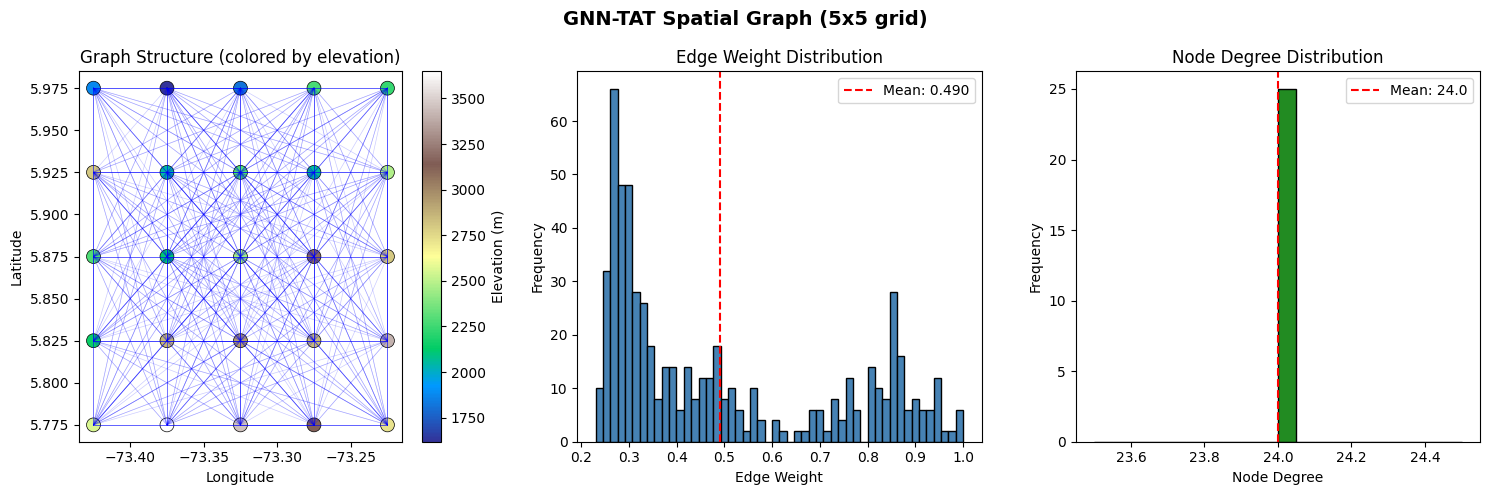

In [6]:
# =============================================================================
# CELL 6: Visualize Graph Structure
# =============================================================================

def visualize_graph(graph_builder: SpatialGraphBuilder, edge_index: np.ndarray,
                   edge_weight: np.ndarray, title: str = "Spatial Graph"):
    """
    Visualize the spatial graph structure.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Node positions with edges
    ax1 = axes[0]
    pos = graph_builder.node_positions

    # Draw edges (sample if too many)
    n_edges_to_draw = min(500, len(edge_weight))
    edge_indices = np.random.choice(len(edge_weight), n_edges_to_draw, replace=False)

    for idx in edge_indices:
        i, j = edge_index[0, idx], edge_index[1, idx]
        ax1.plot([pos[i, 1], pos[j, 1]], [pos[i, 0], pos[j, 0]],
                'b-', alpha=0.2, linewidth=0.5)

    # Draw nodes
    scatter = ax1.scatter(pos[:, 1], pos[:, 0], c=graph_builder.node_elevations,
                         cmap='terrain', s=100, edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter, ax=ax1, label='Elevation (m)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Graph Structure (colored by elevation)')

    # 2. Edge weight distribution
    ax2 = axes[1]
    ax2.hist(edge_weight, bins=50, color='steelblue', edgecolor='black')
    ax2.set_xlabel('Edge Weight')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Edge Weight Distribution')
    ax2.axvline(np.mean(edge_weight), color='red', linestyle='--', label=f'Mean: {np.mean(edge_weight):.3f}')
    ax2.legend()

    # 3. Node degree distribution
    ax3 = axes[2]
    degrees = np.bincount(edge_index[0], minlength=graph_builder.n_nodes)
    ax3.hist(degrees, bins=20, color='forestgreen', edgecolor='black')
    ax3.set_xlabel('Node Degree')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Node Degree Distribution')
    ax3.axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
    ax3.legend()

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save figure
    fig_path = CONFIG['out_root'] / 'graph_visualization.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Graph visualization saved to: {fig_path}")

    plt.show()


# Visualize
visualize_graph(graph_builder, edge_index, edge_weight,
               title=f"GNN-TAT Spatial Graph ({lat}x{lon} grid)")

## 5. Data Preprocessing Pipeline

In [7]:
# =============================================================================
# CELL 7: Data Preprocessing (V2/V3 Compatible)
# =============================================================================

def windowed_arrays(X: np.ndarray, y: np.ndarray, input_window: int,
                   horizon: int, start_indices: List[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create windowed arrays for sequence-to-sequence learning.

    Args:
        X: Input features (T, lat, lon, n_features)
        y: Target variable (T, lat, lon)
        input_window: Number of input timesteps
        horizon: Number of output timesteps
        start_indices: Optional list of valid start indices

    Returns:
        seq_X: (N, input_window, lat, lon, n_features)
        seq_y: (N, horizon, lat, lon)
    """
    seq_X, seq_y = [], []
    T = len(X)

    if T < (input_window + horizon):
        raise ValueError(f"Not enough timesteps ({T}) for windows")

    if start_indices is None:
        start_indices = range(T - input_window - horizon + 1)

    for start in start_indices:
        end_w = start + input_window
        end_y = end_w + horizon

        if end_y > T:
            continue

        Xw = X[start:end_w]
        yw = y[end_w:end_y]

        # Skip windows with NaNs
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue

        seq_X.append(Xw)
        seq_y.append(yw)

    if len(seq_X) == 0:
        raise ValueError("No valid windows created")

    return np.asarray(seq_X, dtype=np.float32), np.asarray(seq_y, dtype=np.float32)


def compute_split_indices(total_steps: int, input_window: int, horizon: int,
                         split_ratio: float) -> Tuple[List[int], List[int]]:
    """
    Return train/validation start indices ensuring no temporal leakage.

    Args:
        total_steps: Total number of timesteps
        input_window: Input window size
        horizon: Prediction horizon
        split_ratio: Train ratio (e.g., 0.8)

    Returns:
        train_indices: List of training window start indices
        val_indices: List of validation window start indices
    """
    cutoff = int(total_steps * split_ratio)
    max_start = total_steps - input_window - horizon + 1

    # Training indices: before cutoff
    train_end = max(0, cutoff - input_window - horizon + 1)
    train_indices = list(range(0, train_end))

    # Validation indices: from cutoff onward
    val_start = min(max_start, max(cutoff, 0))
    val_indices = list(range(val_start, max_start))

    if not train_indices:
        raise ValueError("Empty training set")
    if not val_indices:
        raise ValueError("Empty validation set")

    return train_indices, val_indices


def preprocess_data(ds: xr.Dataset, config: Dict, n_lat: int, n_lon: int,
                   horizon: int) -> Dict[str, Tuple]:
    """
    Preprocess data for all feature sets.

    Returns:
        Dictionary mapping experiment name to (X_tr, y_tr, X_va, y_va, scaler)
    """
    input_window = config['input_window']
    split_ratio = config['train_val_split']

    results = {}

    for exp_name, feature_list in config['feature_sets'].items():
        print(f"\nProcessing experiment: {exp_name}")

        try:
            # Extract features
            feature_arrays = []
            for feat in feature_list:
                if feat in ds.data_vars:
                    arr = ds[feat].values
                elif feat in ds.coords:
                    # Broadcast coordinate to full grid
                    if feat == 'time':
                        continue
                    arr = np.broadcast_to(
                        ds.coords[feat].values.reshape(-1, 1, 1),
                        (len(ds.time), n_lat, n_lon)
                    )
                else:
                    print(f"  WARNING: Feature '{feat}' not found, skipping")
                    continue

                # Ensure 3D shape (T, lat, lon)
                if len(arr.shape) == 2:
                    # Static feature: broadcast to time
                    arr = np.broadcast_to(arr, (len(ds.time), n_lat, n_lon))

                feature_arrays.append(arr)

            # Stack features: (T, lat, lon, n_features)
            X = np.stack(feature_arrays, axis=-1).astype(np.float32)

            # Target: total precipitation
            y = ds['total_precipitation'].values.astype(np.float32)

            print(f"  X shape: {X.shape}")
            print(f"  y shape: {y.shape}")

            # Handle NaN
            X = np.nan_to_num(X, nan=0.0)
            y = np.nan_to_num(y, nan=0.0)

            # Compute split indices
            T = len(ds.time)
            train_idx, val_idx = compute_split_indices(T, input_window, horizon, split_ratio)

            print(f"  Train windows: {len(train_idx)}, Val windows: {len(val_idx)}")

            # Create windows
            X_tr, y_tr = windowed_arrays(X, y, input_window, horizon, train_idx)
            X_va, y_va = windowed_arrays(X, y, input_window, horizon, val_idx)

            # Scale features
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

            # Fit on training data only
            X_tr_flat = X_tr.reshape(-1, X_tr.shape[-1])
            y_tr_flat = y_tr.reshape(-1, 1)

            scaler_X.fit(X_tr_flat)
            scaler_y.fit(y_tr_flat)

            # Transform
            X_tr_shape = X_tr.shape
            X_va_shape = X_va.shape
            y_tr_shape = y_tr.shape
            y_va_shape = y_va.shape

            X_tr_sc = scaler_X.transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr_shape)
            X_va_sc = scaler_X.transform(X_va.reshape(-1, X_va.shape[-1])).reshape(X_va_shape)
            y_tr_sc = scaler_y.transform(y_tr.reshape(-1, 1)).reshape(y_tr_shape)
            y_va_sc = scaler_y.transform(y_va.reshape(-1, 1)).reshape(y_va_shape)

            # Add channel dimension to y: (N, H, lat, lon) -> (N, H, lat, lon, 1)
            y_tr_sc = np.expand_dims(y_tr_sc, -1)
            y_va_sc = np.expand_dims(y_va_sc, -1)

            print(f"  Final shapes: X_tr={X_tr_sc.shape}, y_tr={y_tr_sc.shape}")
            print(f"                X_va={X_va_sc.shape}, y_va={y_va_sc.shape}")

            results[exp_name] = (X_tr_sc, y_tr_sc, X_va_sc, y_va_sc, scaler_y)

        except Exception as e:
            print(f"  ERROR: {e}")
            continue

    return results


# Preprocess data for default horizon
print("Preprocessing data...")
data_splits = preprocess_data(ds, CONFIG, lat, lon, CONFIG['horizon'])

print(f"\nPreprocessing complete. Available experiments: {list(data_splits.keys())}")

Preprocessing data...

Processing experiment: BASIC
  X shape: (518, 5, 5, 12)
  y shape: (518, 5, 5)
  Train windows: 343, Val windows: 33
  Final shapes: X_tr=(343, 60, 5, 5, 12), y_tr=(343, 12, 5, 5, 1)
                X_va=(33, 60, 5, 5, 12), y_va=(33, 12, 5, 5, 1)

Processing experiment: KCE
  X shape: (518, 5, 5, 15)
  y shape: (518, 5, 5)
  Train windows: 343, Val windows: 33
  Final shapes: X_tr=(343, 60, 5, 5, 15), y_tr=(343, 12, 5, 5, 1)
                X_va=(33, 60, 5, 5, 15), y_va=(33, 12, 5, 5, 1)

Processing experiment: PAFC
  X shape: (518, 5, 5, 18)
  y shape: (518, 5, 5)
  Train windows: 343, Val windows: 33
  Final shapes: X_tr=(343, 60, 5, 5, 18), y_tr=(343, 12, 5, 5, 1)
                X_va=(33, 60, 5, 5, 18), y_va=(33, 12, 5, 5, 1)

Preprocessing complete. Available experiments: ['BASIC', 'KCE', 'PAFC']


## 6. GNN-TAT Model Architecture

In [8]:
# =============================================================================
# CELL 8: GNN-TAT Model Definition (PyTorch) - OPTIMIZED
# =============================================================================
# Fixes applied:
# - Proper residual connection in TemporalAttention
# - Batched GNN processing (no Python loop)
# - Reduced model dimensions (~500K params instead of 54M)
# - GCN with add_self_loops=True for stability

class TemporalAttention(nn.Module):
    """
    Multi-Head Temporal Attention module with proper residual connection.
    """

    def __init__(self, input_dim: int, hidden_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()

        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"

        # Query, Key, Value projections
        self.q_proj = nn.Linear(input_dim, hidden_dim)
        self.k_proj = nn.Linear(input_dim, hidden_dim)
        self.v_proj = nn.Linear(input_dim, hidden_dim)

        # Output projection
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)

        # Residual projection (if dimensions differ)
        self.residual_proj = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

        # Layer norm and dropout
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Scaling factor
        self.scale = self.head_dim ** -0.5

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape

        # Save input for residual (with projection if needed)
        residual = self.residual_proj(x)

        # Project to Q, K, V
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Apply attention to values
        attn_output = torch.matmul(attn_probs, V)

        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_dim)
        output = self.out_proj(attn_output)

        # Proper residual connection: residual + dropout(output)
        output = self.layer_norm(residual + self.dropout(output))

        return output


class SpatialGNNEncoder(nn.Module):
    """
    GNN Encoder for spatial dependencies.
    Supports GCN, GAT, and GraphSAGE with proper handling.
    """

    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int,
                 gnn_type: str = 'GAT', num_heads: int = 4, dropout: float = 0.1):
        super().__init__()

        self.num_layers = num_layers
        self.gnn_type = gnn_type
        self.hidden_dim = hidden_dim

        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # GNN layers
        self.gnn_layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        for i in range(num_layers):
            if gnn_type == 'GAT':
                layer = GATConv(
                    in_channels=hidden_dim,
                    out_channels=hidden_dim // num_heads,
                    heads=num_heads,
                    dropout=dropout,
                    concat=True
                )
            elif gnn_type == 'SAGE':
                layer = SAGEConv(
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    aggr='mean'
                )
            else:  # GCN
                layer = GCNConv(
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    add_self_loops=True,  # Add self-loops for GCN stability
                    normalize=True
                )

            self.gnn_layers.append(layer)
            self.norms.append(nn.LayerNorm(hidden_dim))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                edge_weight: torch.Tensor = None) -> torch.Tensor:
        # Input projection
        x = self.input_proj(x)

        # GNN layers with residual connections
        for gnn, norm in zip(self.gnn_layers, self.norms):
            residual = x

            if self.gnn_type == 'GAT':
                x = gnn(x, edge_index)
            elif self.gnn_type == 'SAGE':
                # SAGEConv does not support edge_weight
                x = gnn(x, edge_index)
            else:  # GCN
                x = gnn(x, edge_index, edge_weight)

            x = F.gelu(x)
            x = self.dropout(x)
            x = norm(x + residual)

        return x


class GNN_TAT(nn.Module):
    """
    Graph Neural Network with Temporal Attention - OPTIMIZED.

    Key optimizations:
    - Batched GNN processing using edge_index replication
    - Temporal processing per node (not flattened)
    - Reduced hidden dimensions (~500K params instead of 54M)
    """

    def __init__(self, n_features: int, n_nodes: int, n_lat: int, n_lon: int,
                 horizon: int, config: Dict):
        super().__init__()

        self.n_features = n_features
        self.n_nodes = n_nodes
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.horizon = horizon

        gnn_cfg = config['gnn_config']
        hidden_dim = gnn_cfg['hidden_dim']

        # GNN Encoder
        self.gnn_encoder = SpatialGNNEncoder(
            input_dim=n_features,
            hidden_dim=hidden_dim,
            num_layers=gnn_cfg['num_gnn_layers'],
            gnn_type=gnn_cfg['gnn_type'],
            num_heads=gnn_cfg['num_heads'],
            dropout=gnn_cfg['dropout']
        )

        # Temporal Attention (per node, efficient)
        self.temporal_attention = TemporalAttention(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            num_heads=gnn_cfg['num_temporal_heads'],
            dropout=gnn_cfg['temporal_dropout']
        )

        # LSTM for sequence modeling (per node)
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=gnn_cfg['num_lstm_layers'],
            batch_first=True,
            dropout=gnn_cfg['dropout'] if gnn_cfg['num_lstm_layers'] > 1 else 0
        )

        # Output projection (per node -> horizon predictions)
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(gnn_cfg['dropout']),
            nn.Linear(hidden_dim, horizon)
        )

        self._print_model_info(gnn_cfg)

    def _print_model_info(self, gnn_cfg):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"GNN-TAT Model initialized:")
        print(f"  Input: ({self.n_features} features, {self.n_nodes} nodes)")
        print(f"  Output: (horizon={self.horizon}, {self.n_lat}x{self.n_lon} grid)")
        print(f"  GNN type: {gnn_cfg['gnn_type']}")
        print(f"  Hidden dim: {gnn_cfg['hidden_dim']}")
        print(f"  Parameters: {total_params:,}")

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                edge_weight: torch.Tensor = None) -> torch.Tensor:
        batch_size, seq_len = x.shape[:2]
        device = x.device

        # Reshape: (batch, seq_len, lat, lon, features) -> (batch, seq_len, n_nodes, features)
        x = x.view(batch_size, seq_len, self.n_nodes, self.n_features)

        # BATCHED GNN Processing
        x_flat = x.view(batch_size * seq_len, self.n_nodes, self.n_features)

        # Replicate edge_index for batch processing
        batch_edge_index = self._batch_edge_index(edge_index, batch_size * seq_len, device)
        batch_edge_weight = edge_weight.repeat(batch_size * seq_len) if edge_weight is not None else None

        # Flatten nodes: (batch * seq_len * n_nodes, n_features)
        x_nodes = x_flat.view(-1, self.n_features)

        # Apply GNN
        gnn_out = self.gnn_encoder(x_nodes, batch_edge_index, batch_edge_weight)

        # Reshape back: (batch, seq_len, n_nodes, hidden_dim)
        hidden_dim = gnn_out.shape[-1]
        gnn_out = gnn_out.view(batch_size, seq_len, self.n_nodes, hidden_dim)

        # Temporal Processing (per node)
        temporal_in = gnn_out.permute(0, 2, 1, 3)  # (batch, n_nodes, seq_len, hidden)
        temporal_in = temporal_in.reshape(batch_size * self.n_nodes, seq_len, hidden_dim)

        # Apply temporal attention
        temporal_out = self.temporal_attention(temporal_in)

        # Apply LSTM
        lstm_out, _ = self.lstm(temporal_out)

        # Take last timestep: (batch * n_nodes, hidden)
        lstm_last = lstm_out[:, -1, :]

        # Output Projection
        out = self.output_proj(lstm_last)  # (batch * n_nodes, horizon)

        # Reshape: (batch, n_nodes, horizon) -> (batch, horizon, lat, lon, 1)
        out = out.view(batch_size, self.n_nodes, self.horizon)
        out = out.permute(0, 2, 1)  # (batch, horizon, n_nodes)
        out = out.view(batch_size, self.horizon, self.n_lat, self.n_lon, 1)

        return out

    def _batch_edge_index(self, edge_index: torch.Tensor, num_graphs: int,
                          device: torch.device) -> torch.Tensor:
        """Create batched edge_index by replicating and offsetting indices."""
        num_edges = edge_index.shape[1]

        # Create offsets for each graph
        offsets = torch.arange(num_graphs, device=device) * self.n_nodes
        offsets = offsets.view(-1, 1, 1).expand(-1, 2, num_edges)

        # Replicate edge_index and add offsets
        batch_edge_index = edge_index.unsqueeze(0).expand(num_graphs, -1, -1)
        batch_edge_index = batch_edge_index + offsets

        # Flatten: (num_graphs, 2, num_edges) -> (2, num_graphs * num_edges)
        batch_edge_index = batch_edge_index.permute(1, 0, 2).reshape(2, -1)

        return batch_edge_index


# Create model
print("\nCreating GNN-TAT model...")

# Get number of features from first experiment
first_exp = list(data_splits.keys())[0]
n_features = data_splits[first_exp][0].shape[-1]

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GNN_TAT(
    n_features=n_features,
    n_nodes=graph_builder.n_nodes,
    n_lat=lat,
    n_lon=lon,
    horizon=CONFIG['horizon'],
    config=CONFIG
).to(device)

# Convert graph to torch tensors
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).to(device)
edge_weight_tensor = torch.tensor(edge_weight, dtype=torch.float32).to(device)


Creating GNN-TAT model...
Using device: cuda
GNN-TAT Model initialized:
  Input: (12 features, 25 nodes)
  Output: (horizon=12, 5x5 grid)
  GNN type: GAT
  Hidden dim: 64
  Parameters: 97,932


In [9]:
# =============================================================================
# CELL 9: TensorFlow Wrapper for V2/V3 Compatibility
# =============================================================================

class TFGNNTATWrapper(tf.keras.Model):
    """
    TensorFlow wrapper for PyTorch GNN-TAT model.
    Allows using the same training infrastructure as V2/V3.
    """

    def __init__(self, pytorch_model: nn.Module, edge_index: torch.Tensor,
                 edge_weight: torch.Tensor, device: torch.device):
        super().__init__()

        self.pytorch_model = pytorch_model
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.device = device

        # Placeholder for compatibility
        self._dummy_layer = tf.keras.layers.Dense(1)

    def call(self, inputs, training=False):
        """
        Forward pass with TensorFlow inputs.
        """
        # Convert TF tensor to numpy, then to PyTorch
        if isinstance(inputs, tf.Tensor):
            x_np = inputs.numpy()
        else:
            x_np = inputs

        x_torch = torch.tensor(x_np, dtype=torch.float32).to(self.device)

        # Set training mode
        if training:
            self.pytorch_model.train()
        else:
            self.pytorch_model.eval()

        # Forward pass
        with torch.set_grad_enabled(training):
            output = self.pytorch_model(x_torch, self.edge_index, self.edge_weight)

        # Convert back to TF tensor
        return tf.constant(output.detach().cpu().numpy())


def build_gnn_tat_model(n_features: int, n_lat: int, n_lon: int, horizon: int,
                        graph_builder: SpatialGraphBuilder, config: Dict,
                        edge_index: torch.Tensor, edge_weight: torch.Tensor,
                        device: torch.device) -> Tuple[nn.Module, TFGNNTATWrapper]:
    """
    Build GNN-TAT model and TF wrapper.

    Returns:
        pytorch_model: The PyTorch GNN-TAT model
        tf_wrapper: TensorFlow wrapper for compatibility
    """
    pytorch_model = GNN_TAT(
        n_features=n_features,
        n_nodes=graph_builder.n_nodes,
        n_lat=n_lat,
        n_lon=n_lon,
        horizon=horizon,
        config=config
    ).to(device)

    tf_wrapper = TFGNNTATWrapper(pytorch_model, edge_index, edge_weight, device)

    return pytorch_model, tf_wrapper


# Model registry (V2/V3 compatible format)
MODELS_V4_GNN = {
    'GNN_TAT_GAT': lambda n_feats, n_lat, n_lon, horizon: build_gnn_tat_model(
        n_feats, n_lat, n_lon, horizon, graph_builder,
        {**CONFIG, 'gnn_config': {**CONFIG['gnn_config'], 'gnn_type': 'GAT'}},
        edge_index_tensor, edge_weight_tensor, device
    ),
    'GNN_TAT_SAGE': lambda n_feats, n_lat, n_lon, horizon: build_gnn_tat_model(
        n_feats, n_lat, n_lon, horizon, graph_builder,
        {**CONFIG, 'gnn_config': {**CONFIG['gnn_config'], 'gnn_type': 'SAGE'}},
        edge_index_tensor, edge_weight_tensor, device
    ),
    'GNN_TAT_GCN': lambda n_feats, n_lat, n_lon, horizon: build_gnn_tat_model(
        n_feats, n_lat, n_lon, horizon, graph_builder,
        {**CONFIG, 'gnn_config': {**CONFIG['gnn_config'], 'gnn_type': 'GCN'}},
        edge_index_tensor, edge_weight_tensor, device
    ),
}

print(f"\nV4 GNN-TAT Models registered: {list(MODELS_V4_GNN.keys())}")


V4 GNN-TAT Models registered: ['GNN_TAT_GAT', 'GNN_TAT_SAGE', 'GNN_TAT_GCN']


## 7. Training Infrastructure

In [10]:
# =============================================================================
# CELL 10: PyTorch Training Functions
# =============================================================================

class PrecipitationDataset(Dataset):
    """
    PyTorch Dataset for precipitation prediction.
    """

    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def train_pytorch_model(model: nn.Module, X_tr: np.ndarray, y_tr: np.ndarray,
                        X_va: np.ndarray, y_va: np.ndarray,
                        edge_index: torch.Tensor, edge_weight: torch.Tensor,
                        config: Dict, model_name: str, exp_name: str,
                        out_dir: Path, horizon: int, device: torch.device) -> Tuple[nn.Module, Dict]:
    """
    Train PyTorch GNN-TAT model.

    Returns:
        Trained model and training history
    """
    # Setup output directories
    metrics_dir = out_dir / f'h{horizon}' / exp_name / 'training_metrics'
    metrics_dir.mkdir(parents=True, exist_ok=True)
    model_path = metrics_dir / f"{model_name}_best_h{horizon}.pt"

    # Create data loaders
    train_dataset = PrecipitationDataset(X_tr, y_tr)
    val_dataset = PrecipitationDataset(X_va, y_va)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config.get('weight_decay', 1e-5)
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=config['patience'] // 2
    )

    # Loss function
    criterion = nn.MSELoss()

    # Training tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': [],
        'lr': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    print(f"\nTraining {model_name} on {exp_name}...")
    print(f"  Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        train_losses = []
        train_maes = []

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(batch_X, edge_index, edge_weight)
            loss = criterion(output, batch_y)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_losses.append(loss.item())
            train_maes.append(F.l1_loss(output, batch_y).item())

        # Validation phase
        model.eval()
        val_losses = []
        val_maes = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                output = model(batch_X, edge_index, edge_weight)
                val_losses.append(criterion(output, batch_y).item())
                val_maes.append(F.l1_loss(output, batch_y).item())

        # Compute epoch metrics
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_mae = np.mean(train_maes)
        epoch_val_mae = np.mean(val_maes)
        current_lr = optimizer.param_groups[0]['lr']

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_mae'].append(epoch_train_mae)
        history['val_mae'].append(epoch_val_mae)
        history['lr'].append(current_lr)

        # Learning rate scheduler
        scheduler.step(epoch_val_loss)

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            patience_counter = 0

            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, model_path)
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:3d}/{config['epochs']}: "
                  f"train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}, "
                  f"MAE={epoch_val_mae:.4f}, lr={current_lr:.2e}")

        # Early stopping
        if patience_counter >= config['patience']:
            print(f"  Early stopping at epoch {epoch+1}")
            break

    # Load best model
    checkpoint = torch.load(model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Save training history
    history_df = pd.DataFrame(history)
    history_df.to_csv(metrics_dir / f"{model_name}_training_log_h{horizon}.csv", index=False)

    # Save summary
    summary = {
        'model_name': model_name,
        'experiment': exp_name,
        'horizon': horizon,
        'best_epoch': best_epoch + 1,
        'best_val_loss': float(best_val_loss),
        'final_train_loss': float(history['train_loss'][-1]),
        'final_val_loss': float(history['val_loss'][-1]),
        'total_epochs': len(history['train_loss']),
        'parameters': sum(p.numel() for p in model.parameters())
    }

    with open(metrics_dir / f"{model_name}_history.json", 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"  Training complete. Best val_loss: {best_val_loss:.4f} at epoch {best_epoch+1}")

    return model, summary

In [11]:
# =============================================================================
# CELL 11: Evaluation Functions (V2/V3 Compatible)
# =============================================================================

def evaluate_model(model: nn.Module, X_va: np.ndarray, y_va: np.ndarray,
                   edge_index: torch.Tensor, edge_weight: torch.Tensor,
                   scaler: StandardScaler, device: torch.device,
                   model_name: str, exp_name: str, horizon: int) -> List[Dict]:
    """
    Evaluate model and compute metrics per horizon step.

    Returns:
        List of metric dictionaries (one per horizon step)
    """
    model.eval()
    results = []

    # Predict in batches
    batch_size = 4
    predictions = []

    with torch.no_grad():
        for i in range(0, len(X_va), batch_size):
            batch_X = torch.tensor(X_va[i:i+batch_size], dtype=torch.float32).to(device)
            batch_pred = model(batch_X, edge_index, edge_weight)
            predictions.append(batch_pred.cpu().numpy())

    y_hat_sc = np.concatenate(predictions, axis=0)

    # Inverse transform predictions
    y_hat = scaler.inverse_transform(y_hat_sc.reshape(-1, 1)).reshape(y_hat_sc.shape)
    y_true = scaler.inverse_transform(y_va.reshape(-1, 1)).reshape(y_va.shape)

    # Compute metrics per horizon step
    for h in range(horizon):
        y_h_true = y_true[:, h].flatten()
        y_h_pred = y_hat[:, h].flatten()

        # Metrics
        rmse = np.sqrt(np.mean((y_h_pred - y_h_true) ** 2))
        mae = np.mean(np.abs(y_h_pred - y_h_true))

        ss_res = np.sum((y_h_true - y_h_pred) ** 2)
        ss_tot = np.sum((y_h_true - np.mean(y_h_true)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8))

        results.append({
            'TotalHorizon': horizon,
            'Experiment': exp_name,
            'Model': model_name,
            'H': h + 1,
            'RMSE': rmse,
            'MAE': mae,
            'R^2': r2,
            'Mean_True_mm': np.mean(y_h_true),
            'Mean_Pred_mm': np.mean(y_h_pred),
            'TotalPrecipitation': np.sum(y_h_true),
            'TotalPrecipitation_Pred': np.sum(y_h_pred)
        })

    return results, y_hat, y_true

## 8. Main Training Loop

In [12]:
# =============================================================================
# CELL 12: Main Training Loop (V2/V3 Compatible) - IMPROVED
# =============================================================================
# Changes: Better memory management between experiments

# Results collection
all_results = []
all_histories = {}
all_predictions = {}

for horizon in CONFIG['enabled_horizons']:
    print(f"\n{'='*60}")
    print(f"Running experiments for horizon H={horizon} months")
    print(f"{'='*60}")

    # Preprocess data for this horizon
    data_splits_h = preprocess_data(ds, CONFIG, lat, lon, horizon)

    for exp_name in CONFIG['feature_sets'].keys():
        if exp_name not in data_splits_h:
            print(f"\nSkipping {exp_name}: data not available")
            continue

        print(f"\n--- Experiment: {exp_name} ---")

        X_tr, y_tr, X_va, y_va, scaler = data_splits_h[exp_name]
        n_features = X_tr.shape[-1]

        for model_name in ['GNN_TAT_GAT', 'GNN_TAT_SAGE', 'GNN_TAT_GCN']:
            print(f"\n>>> Model: {model_name}")

            # Clear memory BEFORE creating new model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

            try:
                # Build model
                gnn_type = model_name.split('_')[-1]  # GAT, SAGE, or GCN
                model_config = {**CONFIG, 'gnn_config': {**CONFIG['gnn_config'], 'gnn_type': gnn_type}}

                model = GNN_TAT(
                    n_features=n_features,
                    n_nodes=graph_builder.n_nodes,
                    n_lat=lat,
                    n_lon=lon,
                    horizon=horizon,
                    config=model_config
                ).to(device)

                # Train
                model, history = train_pytorch_model(
                    model, X_tr, y_tr, X_va, y_va,
                    edge_index_tensor, edge_weight_tensor,
                    CONFIG, model_name, exp_name,
                    CONFIG['out_root'], horizon, device
                )

                all_histories[f"{exp_name}_{model_name}_H{horizon}"] = history

                # Evaluate
                results, y_hat, y_true = evaluate_model(
                    model, X_va, y_va,
                    edge_index_tensor, edge_weight_tensor,
                    scaler, device,
                    model_name, exp_name, horizon
                )

                all_results.extend(results)
                all_predictions[f"{exp_name}_{model_name}_H{horizon}"] = {
                    'y_hat': y_hat,
                    'y_true': y_true
                }

                # Print summary metrics
                avg_rmse = np.mean([r['RMSE'] for r in results])
                avg_mae = np.mean([r['MAE'] for r in results])
                avg_r2 = np.mean([r['R^2'] for r in results])
                print(f"  Results: RMSE={avg_rmse:.2f}mm, MAE={avg_mae:.2f}mm, R2={avg_r2:.3f}")

            except Exception as e:
                print(f"  ERROR: {e}")
                import traceback
                traceback.print_exc()

            finally:
                # ALWAYS cleanup after each model
                if 'model' in dir():
                    del model
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()

        # Cleanup after each experiment
        del X_tr, y_tr, X_va, y_va
        gc.collect()

    # Cleanup after each horizon
    del data_splits_h
    gc.collect()

print(f"\n{'='*60}")
print("Training complete!")
print(f"Total experiments: {len(all_results) // CONFIG['horizon'] if all_results else 0}")
print(f"{'='*60}")


Running experiments for horizon H=12 months

Processing experiment: BASIC
  X shape: (518, 5, 5, 12)
  y shape: (518, 5, 5)
  Train windows: 343, Val windows: 33
  Final shapes: X_tr=(343, 60, 5, 5, 12), y_tr=(343, 12, 5, 5, 1)
                X_va=(33, 60, 5, 5, 12), y_va=(33, 12, 5, 5, 1)

Processing experiment: KCE
  X shape: (518, 5, 5, 15)
  y shape: (518, 5, 5)
  Train windows: 343, Val windows: 33
  Final shapes: X_tr=(343, 60, 5, 5, 15), y_tr=(343, 12, 5, 5, 1)
                X_va=(33, 60, 5, 5, 15), y_va=(33, 12, 5, 5, 1)

Processing experiment: PAFC
  X shape: (518, 5, 5, 18)
  y shape: (518, 5, 5)
  Train windows: 343, Val windows: 33
  Final shapes: X_tr=(343, 60, 5, 5, 18), y_tr=(343, 12, 5, 5, 1)
                X_va=(33, 60, 5, 5, 18), y_va=(33, 12, 5, 5, 1)

--- Experiment: BASIC ---

>>> Model: GNN_TAT_GAT
GNN-TAT Model initialized:
  Input: (12 features, 25 nodes)
  Output: (horizon=12, 5x5 grid)
  GNN type: GAT
  Hidden dim: 64
  Parameters: 97,932

Training GNN_TA

## 9. Results Export and Visualization

In [13]:
# =============================================================================
# CELL 13: Save Results (V2/V3 Compatible Format)
# =============================================================================

# Create results DataFrame
res_df = pd.DataFrame(all_results)

# Add bias metrics
res_df['mean_bias_mm'] = res_df['Mean_Pred_mm'] - res_df['Mean_True_mm']
res_df['mean_bias_pct'] = 100 * res_df['mean_bias_mm'] / (res_df['Mean_True_mm'].replace(0, np.nan))

# Save to CSV
horizon_label = 'multi' if len(CONFIG['enabled_horizons']) > 1 else str(CONFIG['enabled_horizons'][0])
out_csv = CONFIG['out_root'] / f'metrics_spatial_v4_gnn_tat_h{horizon_label}.csv'
res_df.to_csv(out_csv, index=False)

print(f"Results saved to: {out_csv}")
print(f"\nResults Summary:")
print(res_df.groupby(['Model', 'Experiment'])[['RMSE', 'MAE', 'R^2']].mean().round(3))

Results saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models/metrics_spatial_v4_gnn_tat_h12.csv

Results Summary:
                              RMSE        MAE    R^2
Model        Experiment                             
GNN_TAT_GAT  BASIC       60.061001  44.334000  0.606
             KCE         63.105000  43.869999  0.567
             PAFC        58.423000  41.439999  0.628
GNN_TAT_GCN  BASIC       63.729000  43.630001  0.558
             KCE         62.772999  44.931999  0.570
             PAFC        58.728001  40.962002  0.625
GNN_TAT_SAGE BASIC       62.554001  42.714001  0.573
             KCE         59.056000  41.823002  0.618
             PAFC        59.230000  42.369999  0.618


Comparison plot saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models/model_comparison_v4_gnn_tat.png


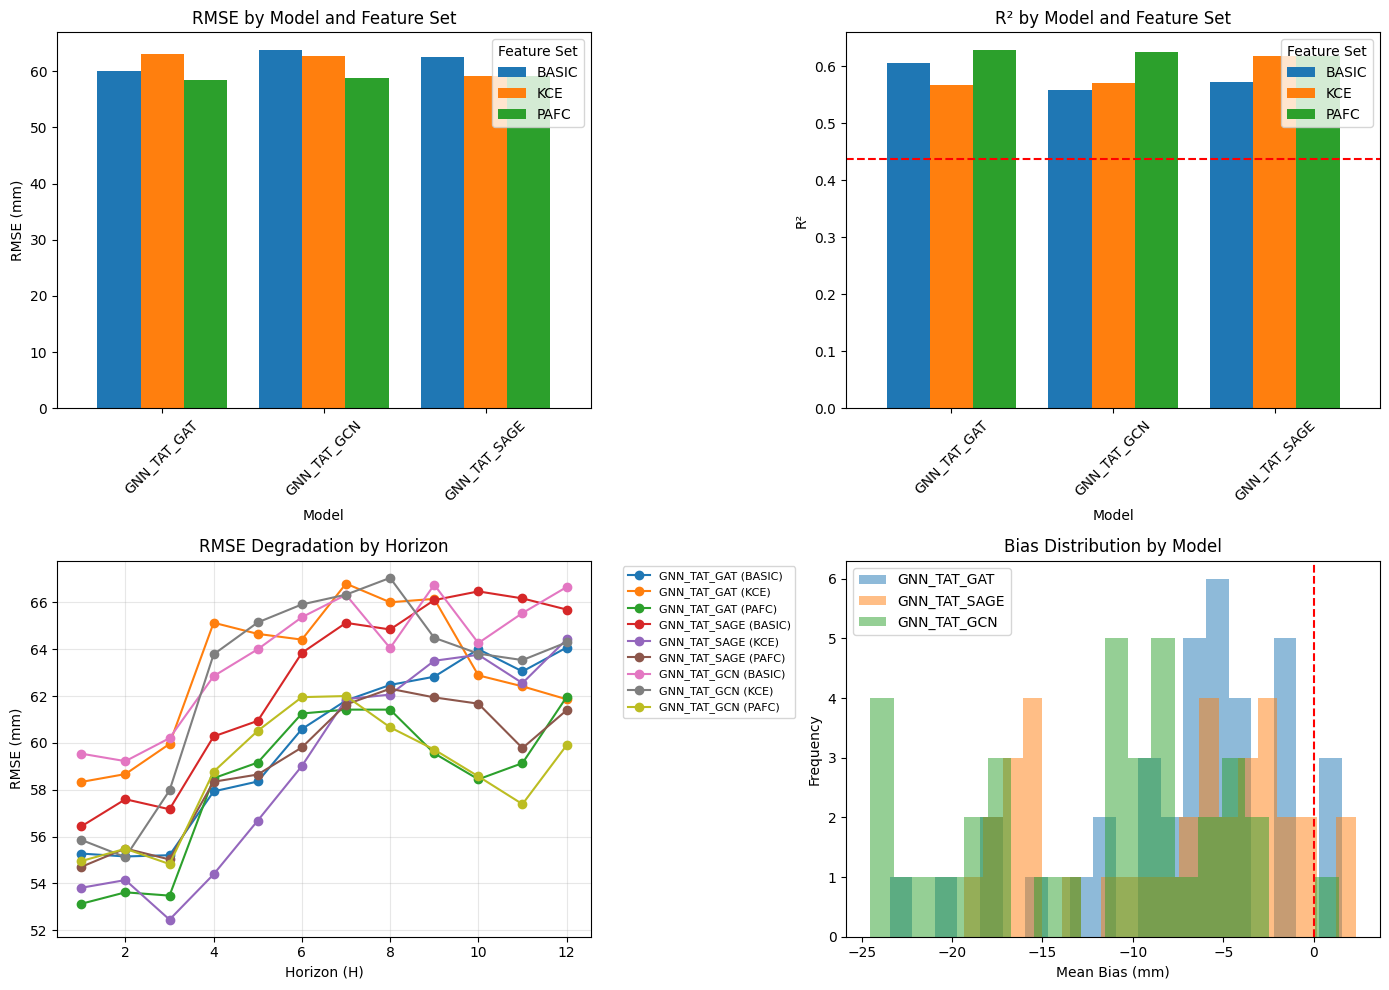

In [14]:
# =============================================================================
# CELL 14: Visualization - Model Comparison
# =============================================================================

def plot_model_comparison(res_df: pd.DataFrame, output_dir: Path):
    """
    Plot model comparison charts.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. RMSE by Model and Experiment
    ax1 = axes[0, 0]
    pivot_rmse = res_df.groupby(['Model', 'Experiment'])['RMSE'].mean().unstack()
    pivot_rmse.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_ylabel('RMSE (mm)')
    ax1.set_title('RMSE by Model and Feature Set')
    ax1.legend(title='Feature Set')
    ax1.tick_params(axis='x', rotation=45)

    # 2. R² by Model and Experiment
    ax2 = axes[0, 1]
    pivot_r2 = res_df.groupby(['Model', 'Experiment'])['R^2'].mean().unstack()
    pivot_r2.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_ylabel('R²')
    ax2.set_title('R² by Model and Feature Set')
    ax2.legend(title='Feature Set')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=0.437, color='red', linestyle='--', label='V2 Baseline (0.437)')

    # 3. RMSE by Horizon
    ax3 = axes[1, 0]
    for model in res_df['Model'].unique():
        model_data = res_df[res_df['Model'] == model]
        for exp in model_data['Experiment'].unique():
            exp_data = model_data[model_data['Experiment'] == exp]
            ax3.plot(exp_data['H'], exp_data['RMSE'],
                    marker='o', label=f"{model} ({exp})")
    ax3.set_xlabel('Horizon (H)')
    ax3.set_ylabel('RMSE (mm)')
    ax3.set_title('RMSE Degradation by Horizon')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)

    # 4. Bias Distribution
    ax4 = axes[1, 1]
    for model in res_df['Model'].unique():
        model_bias = res_df[res_df['Model'] == model]['mean_bias_mm']
        ax4.hist(model_bias, bins=20, alpha=0.5, label=model)
    ax4.axvline(x=0, color='red', linestyle='--')
    ax4.set_xlabel('Mean Bias (mm)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Bias Distribution by Model')
    ax4.legend()

    plt.tight_layout()

    # Save
    fig_path = output_dir / 'model_comparison_v4_gnn_tat.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Comparison plot saved to: {fig_path}")

    plt.show()


if len(all_results) > 0:
    plot_model_comparison(res_df, CONFIG['out_root'])
else:
    print("No results to plot")

Edge analysis saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models/graph_edge_analysis.png


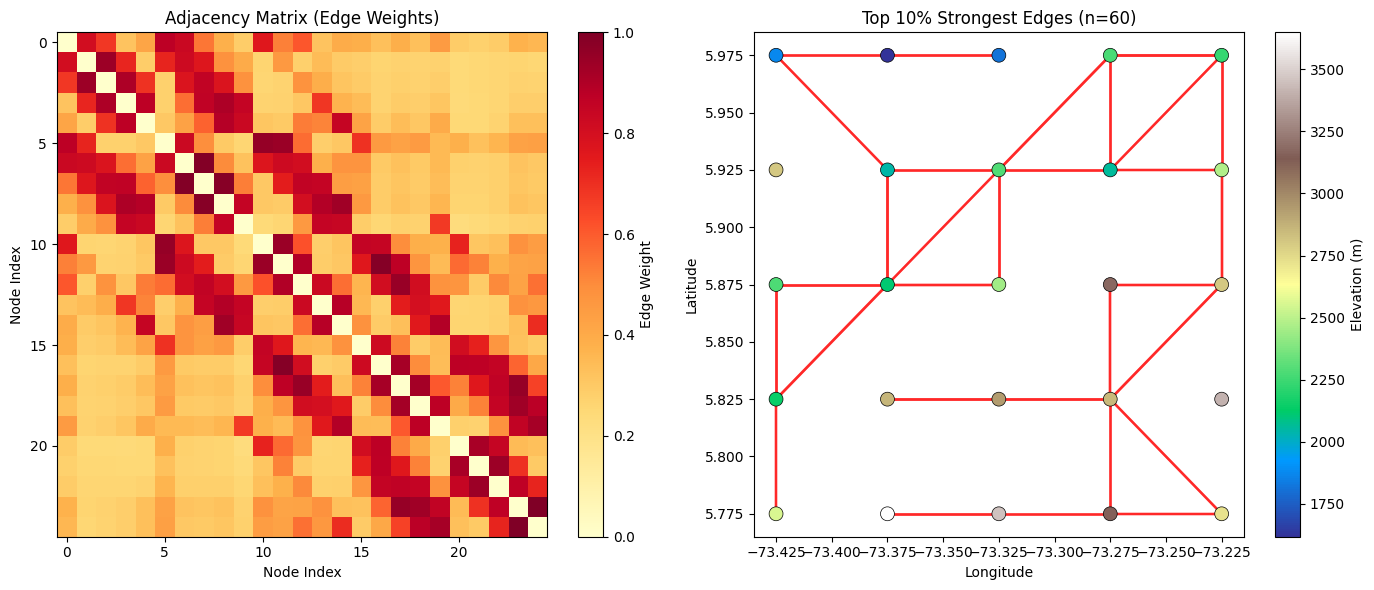


Graph Statistics:
  Total nodes: 25
  Total edges: 600
  Average edge weight: 0.4903
  Max edge weight: 1.0000
  Strong edges (top 10%): 60


In [15]:
# =============================================================================
# CELL 15: Graph Edge Analysis (GNN Interpretability)
# =============================================================================

def analyze_graph_edges(graph_builder: SpatialGraphBuilder, edge_index: np.ndarray,
                        edge_weight: np.ndarray, output_dir: Path):
    """
    Analyze and visualize graph edges for interpretability.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Edge weight heatmap (adjacency matrix)
    ax1 = axes[0]

    # Reconstruct adjacency matrix
    adj_matrix = np.zeros((graph_builder.n_nodes, graph_builder.n_nodes))
    for idx in range(len(edge_weight)):
        i, j = edge_index[0, idx], edge_index[1, idx]
        adj_matrix[i, j] = edge_weight[idx]

    im1 = ax1.imshow(adj_matrix, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im1, ax=ax1, label='Edge Weight')
    ax1.set_xlabel('Node Index')
    ax1.set_ylabel('Node Index')
    ax1.set_title('Adjacency Matrix (Edge Weights)')

    # 2. Strongest edges by location
    ax2 = axes[1]

    # Get top 10% strongest edges
    threshold = np.percentile(edge_weight, 90)
    strong_edges = edge_weight > threshold

    pos = graph_builder.node_positions

    # Draw all nodes
    scatter = ax2.scatter(pos[:, 1], pos[:, 0], c=graph_builder.node_elevations,
                         cmap='terrain', s=100, edgecolors='black', linewidth=0.5,
                         zorder=2)
    plt.colorbar(scatter, ax=ax2, label='Elevation (m)')

    # Draw strong edges
    for idx in np.where(strong_edges)[0]:
        i, j = edge_index[0, idx], edge_index[1, idx]
        ax2.plot([pos[i, 1], pos[j, 1]], [pos[i, 0], pos[j, 0]],
                'r-', alpha=0.6, linewidth=edge_weight[idx] * 2, zorder=1)

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title(f'Top 10% Strongest Edges (n={strong_edges.sum()})')

    plt.tight_layout()

    # Save
    fig_path = output_dir / 'graph_edge_analysis.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Edge analysis saved to: {fig_path}")

    plt.show()

    # Print statistics
    print(f"\nGraph Statistics:")
    print(f"  Total nodes: {graph_builder.n_nodes}")
    print(f"  Total edges: {len(edge_weight)}")
    print(f"  Average edge weight: {np.mean(edge_weight):.4f}")
    print(f"  Max edge weight: {np.max(edge_weight):.4f}")
    print(f"  Strong edges (top 10%): {strong_edges.sum()}")


analyze_graph_edges(graph_builder, edge_index, edge_weight, CONFIG['out_root'])

In [16]:
# =============================================================================
# CELL 16: Export Predictions for Map Generation
# =============================================================================

def export_predictions(predictions_dict: Dict, output_dir: Path, horizon: int):
    """
    Export predictions for map generation (V2/V3 compatible format).
    """
    map_out_root = output_dir / 'map_exports'

    for key, data in predictions_dict.items():
        parts = key.split('_')
        exp_name = parts[0]
        model_name = '_'.join(parts[1:-1])

        export_dir = map_out_root / f'H{horizon}' / exp_name / model_name
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save arrays
        np.save(export_dir / 'predictions.npy', data['y_hat'])
        np.save(export_dir / 'targets.npy', data['y_true'])

        # Save metadata
        metadata = {
            'model': model_name,
            'experiment': exp_name,
            'horizon': horizon,
            'generated_at': datetime.now().isoformat(),
            'shape': list(data['y_hat'].shape),
            'rmse_mean': float(np.sqrt(np.mean((data['y_hat'] - data['y_true'])**2))),
            'framework': 'GNN-TAT V4'
        }

        with open(export_dir / 'metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"Exported: {key}")

    print(f"\nAll predictions exported to: {map_out_root}")


if len(all_predictions) > 0:
    export_predictions(all_predictions, CONFIG['out_root'], CONFIG['horizon'])

Exported: BASIC_GNN_TAT_GAT_H12
Exported: BASIC_GNN_TAT_SAGE_H12
Exported: BASIC_GNN_TAT_GCN_H12
Exported: KCE_GNN_TAT_GAT_H12
Exported: KCE_GNN_TAT_SAGE_H12
Exported: KCE_GNN_TAT_GCN_H12
Exported: PAFC_GNN_TAT_GAT_H12
Exported: PAFC_GNN_TAT_SAGE_H12
Exported: PAFC_GNN_TAT_GCN_H12

All predictions exported to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models/map_exports


## 10. Summary and Next Steps

In [17]:
# =============================================================================
# CELL 17: Final Summary
# =============================================================================

print("="*60)
print("V4 GNN-TAT Training Complete")
print("="*60)

if len(all_results) > 0:
    # Summary statistics
    summary_df = res_df.groupby(['Model', 'Experiment']).agg({
        'RMSE': ['mean', 'std'],
        'MAE': ['mean', 'std'],
        'R^2': ['mean', 'std'],
        'mean_bias_mm': 'mean'
    }).round(3)

    print("\nPerformance Summary:")
    print(summary_df)

    # Best model
    best_idx = res_df.groupby(['Model', 'Experiment'])['R^2'].mean().idxmax()
    best_model, best_exp = best_idx
    best_r2 = res_df.groupby(['Model', 'Experiment'])['R^2'].mean().max()
    best_rmse = res_df[(res_df['Model'] == best_model) & (res_df['Experiment'] == best_exp)]['RMSE'].mean()

    print(f"\nBest Model: {best_model} with {best_exp} features")
    print(f"  R²: {best_r2:.3f}")
    print(f"  RMSE: {best_rmse:.2f} mm")

    # Comparison with V2 baseline
    v2_baseline_r2 = 0.437
    v2_baseline_rmse = 98.17

    r2_improvement = (best_r2 - v2_baseline_r2) / v2_baseline_r2 * 100
    rmse_improvement = (v2_baseline_rmse - best_rmse) / v2_baseline_rmse * 100

    print(f"\nComparison with V2 ConvLSTM Baseline:")
    print(f"  V2 Baseline: R²={v2_baseline_r2:.3f}, RMSE={v2_baseline_rmse:.2f}mm")
    print(f"  V4 GNN-TAT:  R²={best_r2:.3f}, RMSE={best_rmse:.2f}mm")
    print(f"  Improvement: R² {r2_improvement:+.1f}%, RMSE {rmse_improvement:+.1f}%")

print("\n" + "="*60)
print("Output Files:")
print(f"  Metrics CSV: {CONFIG['out_root'] / f'metrics_spatial_v4_gnn_tat_h{horizon_label}.csv'}")
print(f"  Visualizations: {CONFIG['out_root']}")
print(f"  Predictions: {CONFIG['out_root'] / 'map_exports'}")
print("="*60)

V4 GNN-TAT Training Complete

Performance Summary:
                              RMSE               MAE           R^2         \
                              mean    std       mean    std   mean    std   
Model        Experiment                                                     
GNN_TAT_GAT  BASIC       60.061001  3.508  44.334000  3.747  0.606  0.051   
             KCE         63.105000  2.922  43.869999  3.375  0.567  0.039   
             PAFC        58.423000  3.252  41.439999  2.897  0.628  0.043   
GNN_TAT_GCN  BASIC       63.729000  2.729  43.630001  1.722  0.558  0.041   
             KCE         62.772999  4.086  44.931999  3.691  0.570  0.055   
             PAFC        58.728001  2.562  40.962002  1.948  0.625  0.033   
GNN_TAT_SAGE BASIC       62.554001  3.851  42.714001  3.188  0.573  0.056   
             KCE         59.056000  4.496  41.823002  4.212  0.618  0.063   
             PAFC        59.230000  2.815  42.369999  2.522  0.618  0.040   

                        

In [18]:
# =============================================================================
# CELL 18: Save Notebook State
# =============================================================================

# Save complete state for reproducibility
state = {
    'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items() if k != 'feature_sets'},
    'feature_sets': CONFIG['feature_sets'],
    'gnn_config': CONFIG['gnn_config'],
    'grid_info': {
        'lat': lat,
        'lon': lon,
        'n_nodes': graph_builder.n_nodes,
        'n_edges': len(edge_weight)
    },
    'training_summaries': all_histories,
    'timestamp': datetime.now().isoformat()
}

state_path = CONFIG['out_root'] / 'experiment_state_v4.json'
with open(state_path, 'w') as f:
    json.dump(state, f, indent=2, default=str)

print(f"Experiment state saved to: {state_path}")
print("\nV4 GNN-TAT notebook execution complete.")

Experiment state saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V4_GNN_TAT_Models/experiment_state_v4.json

V4 GNN-TAT notebook execution complete.
